In [1]:
#load libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
import seaborn as sns
import importlib
from matplotlib import cm

In [2]:
#load cmif libraries
os.chdir('/mnt/c/Users/engje/Documents/Data/')
from cmif.mplex_image import visualize as viz, process, preprocess, gating

## Notes

add notes about choices for gating strategy

## Load Data

In [3]:
#set location of files
rootdir = '/mnt/c/Users/engje/Documents/Data/PipelineExample'
# go to location of files
os.chdir(rootdir)
preprocess.cmif_mkdir(['GatingPlots'])
#os.listdir()

In [4]:
# 3 define samples to work with/ image combos
ls_sample = ['20200826_BC44290-146']

In [5]:
df_data = pd.DataFrame()
for s_sample in ls_sample:
    df_data = df_data.append(pd.read_csv(f'{s_sample}_ManualPositive.csv',index_col=0))

## Specify Gating Strategy

In [6]:
#parameters

# cell types
ls_endothelial = ['CD31_Ring']
ls_immune = ['CD45_Ring','CD68_Ring','CD3_Ring'] 
ls_tumor = ['CK7_Ring','CK19_Ring','CK5_Ring','CK14_Ring'] 
ls_prolif = ['Ki67_Nuclei']

#tcell/myeloid
s_tcell = 'CD3_Ring' 
s_bcell = 'CD20R_Ring'
s_myeloid = 'CD68_Ring'
ls_immune_functional = ['PD1_Ring','CD44_Ring','prolif'] # not in dataset: 'FoxP3_Nuclei','GRNZB_Nuclei',

#luminal/basal/mesenchymal
ls_luminal = ['CK19_Ring','CK7_Ring'] # not in dataset 'CK8_Ring'
ls_basal = ['CK5_Ring','CK14_Ring','CK17_Ring'] 
ls_mes = ['CD44_Ring', 'Vim_Ring'] 
ls_tumor_plus = ['CD44_Ring'] + ['Lum','Bas','Mes']
ls_stromal_function =  ['Vim_Ring','aSMA_Ring']
ls_tumor_prolif = ['PCNA_Nuclei','Ki67_Nuclei','pHH3_Nuclei']  

#index of cell line samples (i.e. 100% tumor)
ls_cellline_index = []


In [9]:
#importlib.reload(gating)

<module 'cmif.mplex_image.gating' from '/mnt/c/Users/engje/Documents/Data/cmif/mplex_image/gating.py'>

## Perform Gating

In [10]:
%%capture
#custom gating
df_data = gating.main_celltypes(df_data,ls_endothelial,ls_immune,ls_tumor,ls_cellline_index)
df_data = gating.proliferation(df_data,ls_prolif)
df_data = gating.immune_types(df_data,s_myeloid,s_bcell,s_tcell)
df_data = gating.immune_functional(df_data,ls_immune_functional)
df_data = gating.cell_prolif(df_data)
df_data = gating.diff_hr_state(df_data,ls_luminal,ls_basal,ls_mes)

In [11]:
%%capture
#general gating
df_data = gating.celltype_gates(df_data,ls_tumor_prolif,s_new_name='TumorProlif',s_celltype='tumor')
df_data = gating.celltype_gates(df_data,ls_tumor_plus,s_new_name='TumorDiffPlus',s_celltype='tumor')
df_data = gating.celltype_gates(df_data,ls_stromal_function,s_new_name='StromalType',s_celltype='stromal')

In [12]:
df_data = gating.non_tumor(df_data)

## Output Gating Data

In [13]:
#check
#df_data.loc[:,df_data.dtypes=='object']

In [14]:
#drop extra colums
df_gate = df_data.loc[:,df_data.dtypes!='bool']

In [15]:
s_out = '20200828_BC44290-146'
if not os.path.exists(f'{s_out}_GatedPositiveCellNames.csv'):
    print('saving new csv')
    df_gate.to_csv(f'{s_out}_GatedPositiveCellNames.csv')

## Plot


In [17]:
#importlib.reload(viz)

<module 'cmif.mplex_image.visualize' from '/mnt/c/Users/engje/Documents/Data/cmif/mplex_image/visualize.py'>

In [18]:
df_data = pd.read_csv(f'{s_out}_GatedPositiveCellNames.csv',index_col=0)

In [19]:
df_data['scene'] = [item.split('_cell')[0] for item in df_data.index]
#make a fake scene
df_data.loc[df_data[df_data.DAPI_Y > df_data.DAPI_Y.median()].index,'scene'] = 'BC44290-146_scene2'

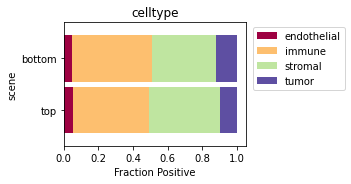

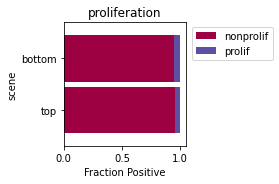

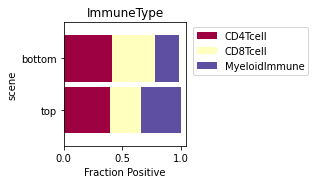

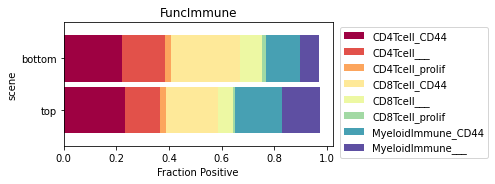

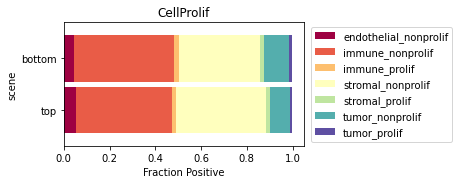

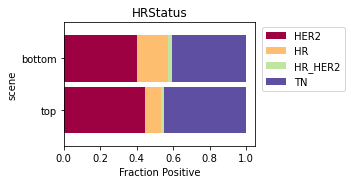

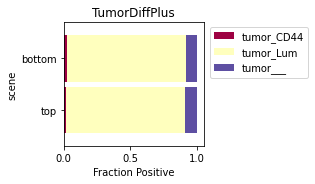

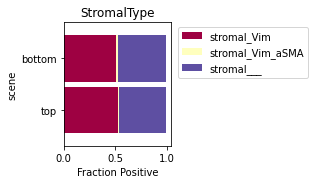

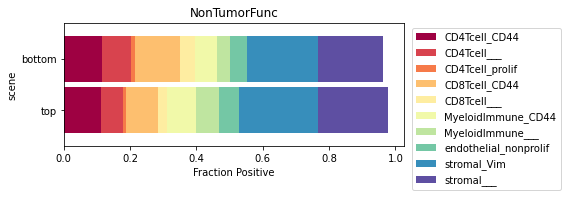

In [20]:
%matplotlib inline
s_grouper='scene'

#calculate proportions
for s_cell in df_data.columns[(df_data.dtypes=='object') & ~(df_data.columns.isin([s_grouper]))].tolist():
    df_prop = viz.prop_positive(df_data,s_cell=s_cell,s_grouper=s_grouper)
    df_prop.rename(index=dict(zip(df_prop.index,['top','bottom'])),inplace=True) 

    # make annotations
    df_annot=pd.DataFrame(data={'ID': df_prop.index.tolist()},index=df_prop.index)
    lut = dict(zip(sorted(df_annot.ID.unique()),cm.tab10.colors))
    g, df_plot_less = viz.prop_clustermap(df_prop,df_annot,i_thresh =.01,lut=lut)
    g.savefig(f'./GatingPlots/{s_cell}_clustermap.png',dpi=150)
    plt.close()
    fig = viz.prop_barplot(df_plot_less,s_cell,colormap="Spectral")
    fig.savefig(f'./GatingPlots/{s_cell}_bar.png',dpi=200)